In [3]:
!pip install scikit-learn scikit-image scipy torch torchvision seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 11.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 109.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from braket.aws import AwsDevice
from braket.circuits import Circuit
from scipy.ndimage import sobel
from scipy.ndimage import zoom
from collections import Counter
from sklearn.decomposition import PCA
import pennylane as qml
import pickle
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.nn import BCELoss

In [5]:
dev = qml.device("braket.local.qubit", wires=2)
num_qubits = 2
num_layers = 3

def extract_features(image):
    """
    Extract edge features from the image using the Sobel filter.

    :param image: 2D numpy array representing the image.
    :return: 2D numpy array representing the edge features.
    """
    sx = sobel(image, axis=0, mode='constant')  # Sobel filter on x-axis
    sy = sobel(image, axis=1, mode='constant')  # Sobel filter on y-axis
    sobel_edges = np.hypot(sx, sy)  # Combine the two gradients
    return sobel_edges


def apply_pca(features, num_components=10):
    """
    Apply PCA to reduce the dimensionality of the image features.

    :param features: Flattened array of image features.
    :param num_components: Number of principal components to keep.
    :return: Reduced feature vector.
    """
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(features.reshape(1, -1))
    return reduced_features.flatten()


def apply_sobel_filter_to_dataset(dataset):
    """
    Apply the Sobel filter to each image in the dataset.

    :param dataset: 3D numpy array where each 2D array represents an image.
    :return: 3D numpy array of images after applying the Sobel filter.
    """
    edge_dataset = np.array([extract_features(image) for image in dataset])
    return edge_dataset

def apply_pca_to_dataset(dataset, num_components=10):
    """
    Apply PCA to reduce the dimensionality of a dataset with edge features.

    :param dataset: 3D numpy array where each 2D array represents an edge-featured image.
    :param num_components: Number of principal components to keep.
    :return: 2D numpy array with reduced dimensionality, PCA model.
    """
    # Flatten each image and stack them into a 2D array
    flattened_images = np.array([image.flatten() for image in dataset])

    # Apply PCA
    pca = PCA(n_components=num_components)
    reduced_dataset = pca.fit_transform(flattened_images)
    return reduced_dataset, pca



# Load MNIST dataset
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples
# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)
# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples],
    np.where(X_train.targets == 1)[0][:n_samples],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], 
    np.where(X_test.targets == 1)[0][:n_samples],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

x_train, y_train, x_test, y_test = X_train.data.numpy(), X_train.targets.numpy(), X_test.data.numpy(), X_test.targets.numpy()

# Apply Sobel filter to both training and test datasets
edge_x_train = apply_sobel_filter_to_dataset(x_train)
edge_x_test = apply_sobel_filter_to_dataset(x_test)

# Apply PCA to the edge feature datasets
reduced_edge_x_train, pca_model = apply_pca_to_dataset(edge_x_train, num_components=num_qubits)
reduced_edge_x_test = pca_model.transform(np.array([image.flatten() for image in edge_x_test]))

# Convert the numpy arrays to PyTorch tensors
reduced_edge_x_train_torch = torch.tensor(reduced_edge_x_train, dtype=torch.float32, requires_grad=False)
reduced_edge_x_test_torch = torch.tensor(reduced_edge_x_test, dtype=torch.float32, requires_grad=False)

# Convert the labels to PyTorch tensors as well
y_train_torch = torch.tensor(y_train, dtype=torch.double)
y_test_torch = torch.tensor(y_test, dtype=torch.double)

def custom_observable(num_qubits):
    # Sum of PauliX, PauliY, and PauliZ for each qubit
    observable = sum([qml.PauliX(i) + qml.PauliY(i) + qml.PauliZ(i) for i in range(num_qubits)])
    return observable

@qml.qnode(dev, interface='torch')
def quantum_circuit(params, features):
    # Amplitude Encoding
    qml.AmplitudeEmbedding(features, wires=range(num_qubits), pad_with=0., normalize=True)

    for l in range(num_layers):
        # Parameterized circuit/Ansatz for classification
        for i in range(num_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Entangling layer
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measurement of the custom observable
    return qml.expval(custom_observable(num_qubits))

params = torch.tensor(np.random.rand(num_layers, num_qubits, 3), requires_grad=True)

criterion = BCELoss()

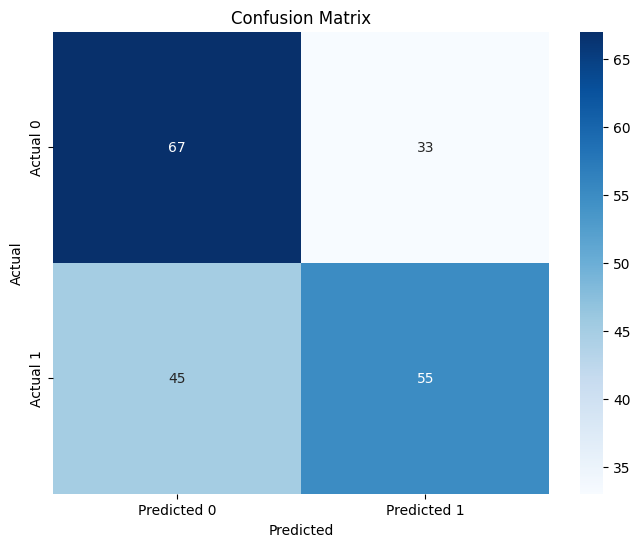

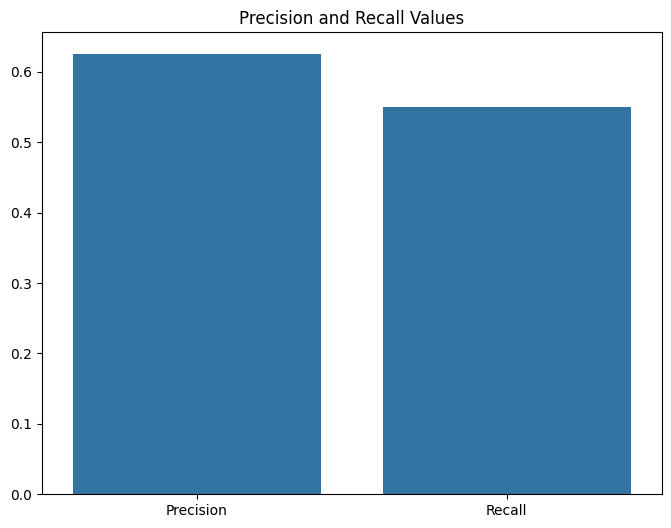

In [6]:
## Testing and evaluating pretrained model
file_path = 'quantum_model_torch_training_data_001_multiemb.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)
    
best_params = data['best_params']
train_accuracies = data['train_accuracies']
train_losses = data['training_losses']
test_accuracies = data['test_accuracies']
test_losses = data['test_losses']

def test_model(circuit, params, test_data, test_labels, criterion):
    total_test_loss = 0
    correct_test = 0
    test_preds = []

    with torch.no_grad():
        for data, label in zip(test_data, test_labels):
            prediction = torch.sigmoid(circuit(params, data))
            pred_label = (prediction >= 0.5).int()
            test_preds.append(pred_label.item())

            loss = criterion(prediction, label)
            total_test_loss += loss.item()
            correct_test += int(pred_label == label)

    avg_test_loss = total_test_loss / len(test_data)
    test_accuracy = correct_test / len(test_data)

    return avg_test_loss, test_accuracy, test_preds

# Call the function to perform testing
avg_test_loss, test_accuracy, test_predictions = test_model(
    quantum_circuit, best_params, reduced_edge_x_test_torch, y_test_torch, criterion
)


from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Assuming test_labels are your actual labels for the test dataset
confusion_mat = confusion_matrix(y_test_torch, test_predictions)
precision, recall, _, _ = precision_recall_fscore_support(y_test_torch, test_predictions, average='binary')

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_torch, test_predictions)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.svg', format='svg')

from sklearn.metrics import precision_recall_fscore_support

# Calculate precision and recall
precision, recall, _, _ = precision_recall_fscore_support(y_test_torch, test_predictions, average='binary')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=['Precision', 'Recall'], y=[precision, recall])
plt.title('Precision and Recall Values')
plt.savefig('precision_recall.svg', format='svg')

## Initial naive experiments 

In [2]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

#dev = qml.device("braket.aws.qubit",device_arn=device_arn,wires=10,)

dev = qml.device("braket.local.qubit", wires=10)

In [13]:
import numpy as np

def extract_features(image):
    """
    Extract edge features from the image using the Sobel filter.

    :param image: 2D numpy array representing the image.
    :return: 2D numpy array representing the edge features.
    """
    sx = sobel(image, axis=0, mode='constant')  # Sobel filter on x-axis
    sy = sobel(image, axis=1, mode='constant')  # Sobel filter on y-axis
    sobel_edges = np.hypot(sx, sy)  # Combine the two gradients
    return sobel_edges


def apply_pca(features, num_components=10):
    """
    Apply PCA to reduce the dimensionality of the image features.

    :param features: Flattened array of image features.
    :param num_components: Number of principal components to keep.
    :return: Reduced feature vector.
    """
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(features.reshape(1, -1))
    return reduced_features.flatten()


def apply_sobel_filter_to_dataset(dataset):
    """
    Apply the Sobel filter to each image in the dataset.

    :param dataset: 3D numpy array where each 2D array represents an image.
    :return: 3D numpy array of images after applying the Sobel filter.
    """
    edge_dataset = np.array([extract_features(image) for image in dataset])
    return edge_dataset

def apply_pca_to_dataset(dataset, num_components=10):
    """
    Apply PCA to reduce the dimensionality of a dataset with edge features.

    :param dataset: 3D numpy array where each 2D array represents an edge-featured image.
    :param num_components: Number of principal components to keep.
    :return: 2D numpy array with reduced dimensionality, PCA model.
    """
    # Flatten each image and stack them into a 2D array
    flattened_images = np.array([image.flatten() for image in dataset])

    # Apply PCA
    pca = PCA(n_components=num_components)
    reduced_dataset = pca.fit_transform(flattened_images)
    return reduced_dataset, pca


num_qubits = 10
# Load MNIST dataset
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples
# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)
# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples],
    np.where(X_train.targets == 1)[0][:n_samples],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], 
    np.where(X_test.targets == 1)[0][:n_samples],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

x_train, y_train, x_test, y_test = X_train.data.numpy(), X_train.targets.numpy(), X_test.data.numpy(), X_test.targets.numpy()

# Apply Sobel filter to both training and test datasets
edge_x_train = apply_sobel_filter_to_dataset(x_train)
edge_x_test = apply_sobel_filter_to_dataset(x_test)

# Apply PCA to the edge feature datasets
reduced_edge_x_train, pca_model = apply_pca_to_dataset(edge_x_train, num_components=num_qubits)
reduced_edge_x_test = pca_model.transform(np.array([image.flatten() for image in edge_x_test]))



In [17]:
from pennylane import numpy as np

@qml.qnode(dev)
def quantum_circuit(params, features):
    # Encoding features into the quantum state
    for i in range(num_qubits):
        if i < len(features):
            qml.RX(features[i], wires=i)
    
    # Parameterized circuit for classification
    for i in range(num_qubits):
        qml.RX(params[i], wires=i)
        qml.RY(params[i + num_qubits], wires=i)
        qml.RZ(params[i + 2 * num_qubits], wires=i)

    # Entangling layer
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[num_qubits - 1, 0])  # Closing the ring

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]


def categorical_crossentropy(y_true, y_pred):
    """
    Compute the categorical crossentropy loss.

    Parameters:
    - y_true: np.array - true labels in one-hot encoded form.
    - y_pred: np.array - predicted probabilities.

    Returns:
    - Loss value (float).
    """
    # Small value to avoid division by zero error
    epsilon = 1e-10

    # Clip predictions to avoid log(0) error
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate crossentropy
    cross_entropy = -np.sum(y_true * np.log(y_pred_clipped), axis=1)

    # Take average
    return np.mean(cross_entropy)

def one_hot_encode(target, num_classes=10):
    # Create a tensor of zeros
    one_hot = np.zeros(num_classes, dtype=np.uint8)
    # Set the index corresponding to the target to 1
    one_hot[target] = 1
    return one_hot

def compute_accuracy_and_loss(circuit, params, test_features, test_labels):
    correct = 0
    total = len(test_labels)
    total_loss = 0

    for f, l in zip(test_features, test_labels):
        prediction = circuit(params, f)
        prediction_array = np.array(prediction)
        target_one_hot = one_hot_encode(l)
        total_loss += categorical_crossentropy(target_one_hot.reshape(1,-1), prediction_array.reshape(1,-1))

        predicted_class = np.argmax(prediction)
        if predicted_class == l:
            correct += 1

    accuracy = correct / total
    average_loss = total_loss / total
    return accuracy, average_loss

# Cost Function
def cost_function(params, features, labels):
    loss = 0
    for f, l in zip(features, labels):
        prediction = quantum_circuit(params, f)
        prediction_array = np.array(prediction)

        # Convert labels to one-hot encoding
        target_one_hot = one_hot_encode(l)

        # Calculate loss
        loss += categorical_crossentropy(target_one_hot.reshape(1,-1), prediction_array.reshape(1,-1))
    return loss / len(features)


# Initialize parameters
params = np.array(np.random.rand(3 * num_qubits), requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.1)

cost_function(params,reduced_edge_x_train[:10],y_train[:10])




tensor(17.10161859, requires_grad=True)

In [18]:
iterations = 300
batch_size = 16

losses = []
test_accuracies = []
test_losses = []
best_accuracy = 0
best_params = None

test_indices = np.random.choice(len(reduced_edge_x_test), 5, replace=False)
# while len(np.unique(y_test[test_indices])) < 8:
#     test_indices = np.random.choice(len(preprocessed_test), 10, replace=False)
#     print(np.unique(y_test[test_indices]))

for i in range(iterations):
    batch_indices = np.random.choice(len(reduced_edge_x_train), batch_size, replace=False)
    # Sample a batch of features and labels
    features_batch = reduced_edge_x_train[batch_indices]
    labels_batch = y_train[batch_indices]

    # Optimize parameters
    params, loss = opt.step_and_cost(lambda v: cost_function(v, features_batch, labels_batch), params)
    losses.append(loss)

    # Compute test accuracy
    test_accuracy, test_loss = compute_accuracy_and_loss(quantum_circuit, params, reduced_edge_x_test[test_indices], y_test[test_indices])
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Update best accuracy and save parameters if current accuracy is better
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = np.copy(params)  # Save a copy of the best parameters
        data_to_save = {
            "best_params": best_params,
            "training_losses": losses,
            "test_accuracies": test_accuracies,
            "test_losses": test_losses
        }

        # Save the data to a file
        filename = 'quantum_model_training_data.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(data_to_save, file)
        print(f"Training data saved to {filename}")

    print(f"Iteration {i+1}, Loss: {loss}, Test Accuracy: {test_accuracy}")


Iteration 1, Loss: 16.02395859716622, Test Accuracy: 0.0
Iteration 2, Loss: 12.351544659407859, Test Accuracy: 0.0
Iteration 3, Loss: 15.247138755895927, Test Accuracy: 0.0
Iteration 4, Loss: 13.635862994568766, Test Accuracy: 0.0
Iteration 5, Loss: 11.56471519194016, Test Accuracy: 0.0
Iteration 6, Loss: 15.225683481843426, Test Accuracy: 0.0
Iteration 7, Loss: 7.974525299714916, Test Accuracy: 0.0
Iteration 8, Loss: 11.730379825792681, Test Accuracy: 0.0
Iteration 9, Loss: 16.818987183993247, Test Accuracy: 0.0
Iteration 10, Loss: 13.830953946200488, Test Accuracy: 0.0
Iteration 11, Loss: 13.734728552945363, Test Accuracy: 0.0
Iteration 12, Loss: 11.680190744391332, Test Accuracy: 0.0
Iteration 13, Loss: 12.411639725931488, Test Accuracy: 0.0
Iteration 14, Loss: 12.919003400752603, Test Accuracy: 0.0
Iteration 15, Loss: 9.940883034822544, Test Accuracy: 0.0
Iteration 16, Loss: 13.012264448247144, Test Accuracy: 0.0
Iteration 17, Loss: 17.93253760620202, Test Accuracy: 0.0
Training da

In [3]:
import numpy as np

def extract_features(image):
    """
    Extract edge features from the image using the Sobel filter.

    :param image: 2D numpy array representing the image.
    :return: 2D numpy array representing the edge features.
    """
    sx = sobel(image, axis=0, mode='constant')  # Sobel filter on x-axis
    sy = sobel(image, axis=1, mode='constant')  # Sobel filter on y-axis
    sobel_edges = np.hypot(sx, sy)  # Combine the two gradients
    return sobel_edges


def apply_pca(features, num_components=10):
    """
    Apply PCA to reduce the dimensionality of the image features.

    :param features: Flattened array of image features.
    :param num_components: Number of principal components to keep.
    :return: Reduced feature vector.
    """
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(features.reshape(1, -1))
    return reduced_features.flatten()


def apply_sobel_filter_to_dataset(dataset):
    """
    Apply the Sobel filter to each image in the dataset.

    :param dataset: 3D numpy array where each 2D array represents an image.
    :return: 3D numpy array of images after applying the Sobel filter.
    """
    edge_dataset = np.array([extract_features(image) for image in dataset])
    return edge_dataset

def apply_pca_to_dataset(dataset, num_components=10):
    """
    Apply PCA to reduce the dimensionality of a dataset with edge features.

    :param dataset: 3D numpy array where each 2D array represents an edge-featured image.
    :param num_components: Number of principal components to keep.
    :return: 2D numpy array with reduced dimensionality, PCA model.
    """
    # Flatten each image and stack them into a 2D array
    flattened_images = np.array([image.flatten() for image in dataset])

    # Apply PCA
    pca = PCA(n_components=num_components)
    reduced_dataset = pca.fit_transform(flattened_images)
    return reduced_dataset, pca


num_qubits = 2
# Load MNIST dataset
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples
# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)
# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples],
    np.where(X_train.targets == 1)[0][:n_samples],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], 
    np.where(X_test.targets == 1)[0][:n_samples],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

x_train, y_train, x_test, y_test = X_train.data.numpy(), X_train.targets.numpy(), X_test.data.numpy(), X_test.targets.numpy()

# Apply Sobel filter to both training and test datasets
edge_x_train = apply_sobel_filter_to_dataset(x_train)
edge_x_test = apply_sobel_filter_to_dataset(x_test)

# Apply PCA to the edge feature datasets
reduced_edge_x_train, pca_model = apply_pca_to_dataset(edge_x_train, num_components=num_qubits)
reduced_edge_x_test = pca_model.transform(np.array([image.flatten() for image in edge_x_test]))

from pennylane import numpy as np


@qml.qnode(dev)
def quantum_circuit(params, features):
    # Encoding features into the quantum state
    for i in range(num_qubits):
        if i < len(features):
            qml.RX(features[i], wires=i)
    
    # Parameterized circuit for classification
    for i in range(num_qubits):
        qml.RX(params[i], wires=i)
        qml.RY(params[i + num_qubits], wires=i)
        qml.RZ(params[i + 2 * num_qubits], wires=i)

    # Entangling layer
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[num_qubits - 1, 0])  # Closing the ring

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]


def categorical_crossentropy(y_true, y_pred):
    """
    Compute the categorical crossentropy loss.

    Parameters:
    - y_true: np.array - true labels in one-hot encoded form.
    - y_pred: np.array - predicted probabilities.

    Returns:
    - Loss value (float).
    """
    # Small value to avoid division by zero error
    epsilon = 1e-10

    # Clip predictions to avoid log(0) error
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate crossentropy
    cross_entropy = -np.sum(y_true * np.log(y_pred_clipped), axis=1)

    # Take average
    return np.mean(cross_entropy)

def one_hot_encode(target, num_classes=10):
    # Create a tensor of zeros
    one_hot = np.zeros(num_classes, dtype=np.uint8)
    # Set the index corresponding to the target to 1
    one_hot[target] = 1
    return one_hot

def compute_accuracy_and_loss(circuit, params, test_features, test_labels):
    correct = 0
    total = len(test_labels)
    total_loss = 0

    for f, l in zip(test_features, test_labels):
        prediction = circuit(params, f)
        prediction_array = np.array(prediction)
        target_one_hot = one_hot_encode(l, num_classes=num_qubits)
        total_loss += categorical_crossentropy(target_one_hot.reshape(1,-1), prediction_array.reshape(1,-1))

        predicted_class = np.argmax(prediction)
        if predicted_class == l:
            correct += 1

    accuracy = correct / total
    average_loss = total_loss / total
    return accuracy, average_loss

# Cost Function
def cost_function(params, features, labels):
    loss = 0
    for f, l in zip(features, labels):
        prediction = quantum_circuit(params, f)
        prediction_array = np.array(prediction)

        # Convert labels to one-hot encoding
        target_one_hot = one_hot_encode(l, num_classes=num_qubits)

        # Calculate loss
        loss += categorical_crossentropy(target_one_hot.reshape(1,-1), prediction_array.reshape(1,-1))
    return loss / len(features)


# Initialize parameters
params = np.array(np.random.rand(3 * num_qubits), requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.5)

print(cost_function(params,reduced_edge_x_train[:10],y_train[:10]))




iterations = 200
batch_size = 32

losses2 = []
test_accuracies2 = []
test_losses2 = []
best_accuracy2 = 0
best_params2 = None

# while len(np.unique(y_test[test_indices])) < 8:
#     test_indices = np.random.choice(len(preprocessed_test), 10, replace=False)
#     print(np.unique(y_test[test_indices]))

for i in range(iterations):
    # Training
    total_train_loss = 0
    # for j in range(0, len(reduced_edge_x_train), batch_size):
    #     # Get batch
    #     batch_indices = np.arange(j, min(j + batch_size, len(reduced_edge_x_train)))
    #     features_batch = reduced_edge_x_train[batch_indices]
    #     labels_batch = y_train[batch_indices]

    # Optimize parameters
    params, loss = opt.step_and_cost(lambda v: cost_function(v, reduced_edge_x_train, y_train), params)
    total_train_loss += loss.item()
    #avg_train_loss = total_train_loss / (len(reduced_edge_x_train))
    losses2.append(total_train_loss)

    # Testing
    total_test_loss = 0
    correct_test = 0
    # for j in range(0, len(reduced_edge_x_test), batch_size):
    #     test_indices = np.arange(j, min(j + batch_size, len(reduced_edge_x_test)))
    #     test_features_batch = reduced_edge_x_test[test_indices]
    #     test_labels_batch = y_test[test_indices]

    test_accuracy, test_loss = compute_accuracy_and_loss(quantum_circuit, params, reduced_edge_x_test, y_test)
    # total_test_loss += test_loss
    # correct_test += test_accuracy * len(test_indices)
    # avg_test_loss = total_test_loss / (len(reduced_edge_x_test) / batch_size)
    # avg_test_accuracy = correct_test / len(reduced_edge_x_test)
    test_accuracies2.append(test_accuracy)
    test_losses2.append(test_loss)

    # Update best accuracy and save parameters if current accuracy is better
    if test_accuracy > best_accuracy2:
        best_accuracy2 = test_accuracy
        best_params2 = np.copy(params)  # Save a copy of the best parameters
        data_to_save = {
            "best_params": best_params2,
            "training_losses": losses2,
            "test_accuracies": test_accuracies2,
            "test_losses": test_losses2
        }

        # Save the data to a file
        filename = 'quantum_model_training_data2.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(data_to_save, file)
        print(f"Best model saved to {filename}")

    print(f"Iteration {i+1}, Loss: {total_train_loss}, Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


10.326806795258527
Best model saved to quantum_model_training_data2.pkl
Iteration 1, Loss: 13.48984105483858, Test Accuracy: 0.55, Test Loss: 11.730159463961037
Best model saved to quantum_model_training_data2.pkl
Iteration 2, Loss: 13.338925759973806, Test Accuracy: 0.555, Test Loss: 11.828906952230756
Iteration 3, Loss: 13.26617025361853, Test Accuracy: 0.55, Test Loss: 11.880416522686515
Iteration 4, Loss: 13.532962226007546, Test Accuracy: 0.545, Test Loss: 11.896197481566647
Iteration 5, Loss: 13.361834223393176, Test Accuracy: 0.55, Test Loss: 11.749647887911237
Iteration 6, Loss: 13.273015393958492, Test Accuracy: 0.545, Test Loss: 11.611045191497853
Best model saved to quantum_model_training_data2.pkl
Iteration 7, Loss: 13.035715450109558, Test Accuracy: 0.565, Test Loss: 10.905553157154863
Iteration 8, Loss: 12.476582559769938, Test Accuracy: 0.565, Test Loss: 11.107479695480192
Best model saved to quantum_model_training_data2.pkl
Iteration 9, Loss: 12.324613092988969, Test Ac

KeyboardInterrupt: 

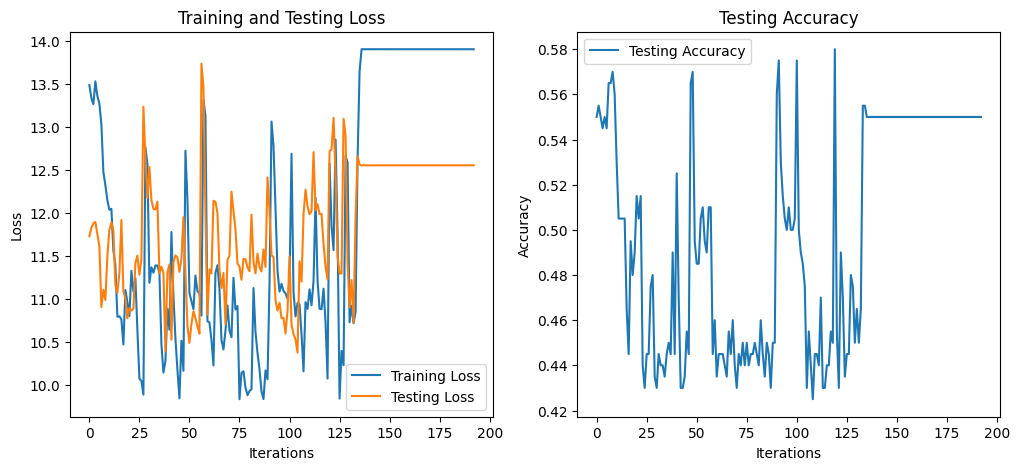

In [4]:
import matplotlib.pyplot as plt

# Plot Training and Testing Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses2, label='Training Loss')
plt.plot(test_losses2, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Save the loss plot as SVG
plt.savefig('training_testing_loss_VQ.svg', format='svg')

# Plot Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies2, label='Testing Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

# Save the accuracy plot as SVG
plt.savefig('testing_accuracy_VQ.svg', format='svg')

plt.show()


## Better implementation and results 

In [201]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from braket.aws import AwsDevice
from braket.circuits import Circuit
from scipy.ndimage import sobel
from scipy.ndimage import zoom
from collections import Counter
from sklearn.decomposition import PCA
import pennylane as qml
import pickle
import torch
from torch.nn import BCELoss
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
from torchvision import datasets, transforms

        
def extract_features(image):
    """
    Extract edge features from the image using the Sobel filter.

    :param image: 2D numpy array representing the image.
    :return: 2D numpy array representing the edge features.
    """
    sx = sobel(image, axis=0, mode='constant')  # Sobel filter on x-axis
    sy = sobel(image, axis=1, mode='constant')  # Sobel filter on y-axis
    sobel_edges = np.hypot(sx, sy)  # Combine the two gradients
    return sobel_edges


def apply_pca(features, num_components=10):
    """
    Apply PCA to reduce the dimensionality of the image features.

    :param features: Flattened array of image features.
    :param num_components: Number of principal components to keep.
    :return: Reduced feature vector.
    """
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(features.reshape(1, -1))
    return reduced_features.flatten()


def apply_sobel_filter_to_dataset(dataset):
    """
    Apply the Sobel filter to each image in the dataset.

    :param dataset: 3D numpy array where each 2D array represents an image.
    :return: 3D numpy array of images after applying the Sobel filter.
    """
    edge_dataset = np.array([extract_features(image) for image in dataset])
    return edge_dataset

def apply_pca_to_dataset(dataset, num_components=10):
    """
    Apply PCA to reduce the dimensionality of a dataset with edge features.

    :param dataset: 3D numpy array where each 2D array represents an edge-featured image.
    :param num_components: Number of principal components to keep.
    :return: 2D numpy array with reduced dimensionality, PCA model.
    """
    # Flatten each image and stack them into a 2D array
    flattened_images = np.array([image.flatten() for image in dataset])

    # Apply PCA
    pca = PCA(n_components=num_components)
    reduced_dataset = pca.fit_transform(flattened_images)
    return reduced_dataset, pca


num_qubits = 2
# Load MNIST dataset
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples
# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)
# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples],
    np.where(X_train.targets == 1)[0][:n_samples],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], 
    np.where(X_test.targets == 1)[0][:n_samples],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

x_train, y_train, x_test, y_test = X_train.data.numpy(), X_train.targets.numpy(), X_test.data.numpy(), X_test.targets.numpy()

# Apply Sobel filter to both training and test datasets
edge_x_train = apply_sobel_filter_to_dataset(x_train)
edge_x_test = apply_sobel_filter_to_dataset(x_test)

# Apply PCA to the edge feature datasets
reduced_edge_x_train, pca_model = apply_pca_to_dataset(edge_x_train, num_components=num_qubits)
reduced_edge_x_test = pca_model.transform(np.array([image.flatten() for image in edge_x_test]))

# Convert the numpy arrays to PyTorch tensors
reduced_edge_x_train_torch = torch.tensor(reduced_edge_x_train, dtype=torch.float32, requires_grad=False)
reduced_edge_x_test_torch = torch.tensor(reduced_edge_x_test, dtype=torch.float32, requires_grad=False)

# Convert the labels to PyTorch tensors as well
y_train_torch = torch.tensor(y_train, dtype=torch.double)
y_test_torch = torch.tensor(y_test, dtype=torch.double)


In [93]:
import numpy as np
import torch
from torch.nn import BCELoss

In [ ]:
num_qubits = 2
num_layers = 3
dev = qml.device("braket.local.qubit", wires=num_qubits)

# Define a custom observable
def custom_observable(num_qubits):
    # Sum of PauliX, PauliY, and PauliZ for each qubit
    observable = sum([qml.PauliX(i) + qml.PauliY(i) + qml.PauliZ(i) for i in range(num_qubits)])
    return observable

@qml.qnode(dev, interface='torch')
def quantum_circuit(params, features):
    # Amplitude Encoding
    qml.AmplitudeEmbedding(features, wires=range(num_qubits), pad_with=0., normalize=True)

    for l in range(num_layers):
        # Parameterized circuit/Ansatz for classification
        for i in range(num_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Entangling layer
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measurement of the custom observable
    return qml.expval(custom_observable(num_qubits))

def compute_accuracy_and_loss(circuit, params, feature, label):
    correct = 0

    prediction = circuit(params, feature)
    pred_label = (torch.abs(prediction) >= 0.5).int()
    loss = criterion(torch.abs(prediction), label)

    if pred_label == label:
        correct = 1

    return correct, loss

# # Cost Function
def cost(params, feature, label):
    #print((torch.abs(quantum_circuit(params, feature)) >= 0.5).int(),torch.abs(quantum_circuit(params, feature)), label)
    return criterion(torch.abs(quantum_circuit(params, feature)), label)


# # Initialize parameters
#params = torch.tensor(np.random.rand(3 * num_qubits), requires_grad=True)
params = torch.tensor(np.random.rand(num_layers, num_qubits, 3), requires_grad=True)
# opt = qml.GradientDescentOptimizer(stepsize=0.5)

# print(cost_function(params,reduced_edge_x_train[:10],y_train[:10]))

opt = torch.optim.Adam([params], lr = 0.001)
criterion = BCELoss()
epochs = 200



# Initialize variables to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
best_accuracy = 0
best_params = None

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0
    
    # Training
    for data, label in zip(reduced_edge_x_train_torch, y_train_torch):
        opt.zero_grad()
        correct, loss = compute_accuracy_and_loss(quantum_circuit, params, data, label)
        correct_train += correct
        total_loss += loss.item()
        # Calculate the gradients
        loss.backward()
        # Do the gradient update
        opt.step()
    
    avg_train_loss = total_loss / len(reduced_edge_x_train_torch)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / len(reduced_edge_x_train_torch)
    train_accuracies.append(train_accuracy)

    # Testing
    total_test_loss = 0
    correct_test = 0
    with torch.no_grad():
        for data, label in zip(reduced_edge_x_test_torch, y_test_torch):
            correct, loss = compute_accuracy_and_loss(quantum_circuit, params, data, label)
            total_test_loss += loss.item()
            correct_test += correct

    avg_test_loss = total_test_loss / len(reduced_edge_x_test_torch)
    test_accuracy = correct_test / len(reduced_edge_x_test_torch)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params.clone()  # Clone the best parameters
        data_to_save = {
            "best_params": best_params,
            "train_accuracies": train_accuracies,
            "training_losses": train_losses,
            "test_accuracies": test_accuracies,
            "test_losses": test_losses
        }

        # Save the data to a file
        filename = 'quantum_model_torch_training_data_001.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(data_to_save, file)
        print(f"Best model saved to {filename}")

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Best model saved to quantum_model_torch_training_data_001.pkl
Epoch 1/200, Train Loss: 1.0673, Train Accuracy: 0.4650, Test Loss: 0.8221, Test Accuracy: 0.4950
Best model saved to quantum_model_torch_training_data_001.pkl
Epoch 2/200, Train Loss: 0.8415, Train Accuracy: 0.4750, Test Loss: 0.7619, Test Accuracy: 0.5050
Epoch 3/200, Train Loss: 0.7842, Train Accuracy: 0.4750, Test Loss: 0.7250, Test Accuracy: 0.5050
Best model saved to quantum_model_torch_training_data_001.pkl
Epoch 4/200, Train Loss: 0.7462, Train Accuracy: 0.4750, Test Loss: 0.7003, Test Accuracy: 0.5200
Best model saved to quantum_model_torch_training_data_001.pkl
Epoch 5/200, Train Loss: 0.7199, Train Accuracy: 0.4850, Test Loss: 0.6834, Test Accuracy: 0.5400
Best model saved to quantum_model_torch_training_data_001.pkl
Epoch 6/200, Train Loss: 0.7020, Train Accuracy: 0.5000, Test Loss: 0.6724, Test Accuracy: 0.5700
Best model saved to quantum_model_torch_training_data_001.pkl
Epoch 7/200, Train Loss: 0.6904, Train A

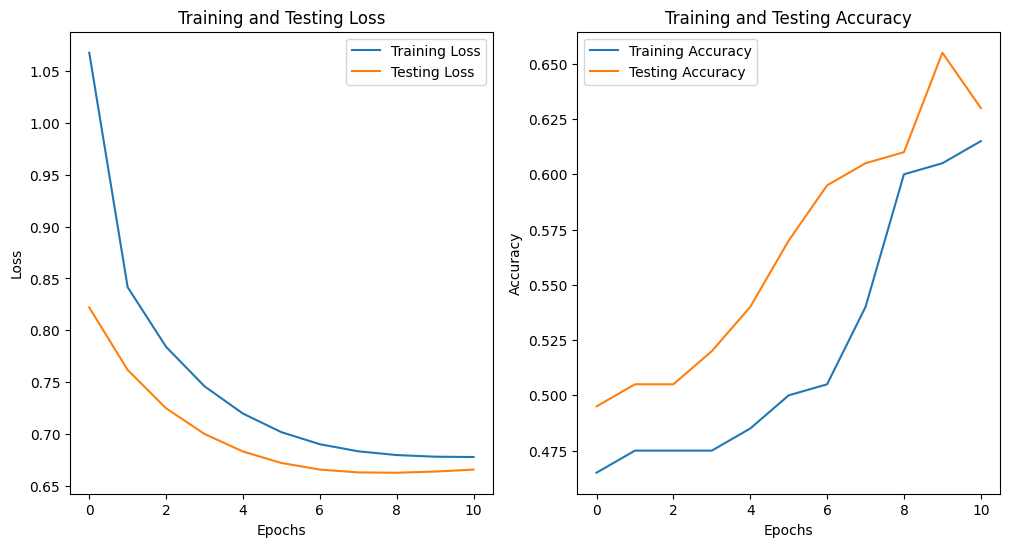

In [120]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Testing Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses[:11], label='Training Loss')
plt.plot(test_losses[:11], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies[:11], label='Training Accuracy')
plt.plot(test_accuracies[:11], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Save the plots as SVG files
plt.savefig('torch_training_testing_plots_001.svg', format='svg')

plt.show()

In [40]:
print(quantum_circuit(params,reduced_edge_x_train_torch[0]))

[tensor(-0.6501, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>), tensor(0.0788, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>)]


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(reduced_edge_x_train, y_train)

# Predict on the test set
y_pred = model.predict(reduced_edge_x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9800


In [18]:
from sklearn.svm import SVC

# Create and train the SVM model
model = SVC()
model.fit(reduced_edge_x_train, y_train)

# Predict on the test set
y_pred = model.predict(reduced_edge_x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9900


In [198]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from braket.aws import AwsDevice
from braket.circuits import Circuit
from scipy.ndimage import sobel
from scipy.ndimage import zoom
from collections import Counter
from sklearn.decomposition import PCA
import pennylane as qml
import pickle
import torch
from torch.nn import BCELoss
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
from torchvision import datasets, transforms

def extract_features(image):
    """
    Extract edge features from the image using the Sobel filter.

    :param image: 2D numpy array representing the image.
    :return: 2D numpy array representing the edge features.
    """
    sx = sobel(image, axis=0, mode='constant')  # Sobel filter on x-axis
    sy = sobel(image, axis=1, mode='constant')  # Sobel filter on y-axis
    sobel_edges = np.hypot(sx, sy)  # Combine the two gradients
    return sobel_edges


def apply_pca(features, num_components=10):
    """
    Apply PCA to reduce the dimensionality of the image features.

    :param features: Flattened array of image features.
    :param num_components: Number of principal components to keep.
    :return: Reduced feature vector.
    """
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(features.reshape(1, -1))
    return reduced_features.flatten()


def apply_sobel_filter_to_dataset(dataset):
    """
    Apply the Sobel filter to each image in the dataset.

    :param dataset: 3D numpy array where each 2D array represents an image.
    :return: 3D numpy array of images after applying the Sobel filter.
    """
    edge_dataset = np.array([extract_features(image) for image in dataset])
    return edge_dataset

def apply_pca_to_dataset(dataset, num_components=10):
    """
    Apply PCA to reduce the dimensionality of a dataset with edge features.

    :param dataset: 3D numpy array where each 2D array represents an edge-featured image.
    :param num_components: Number of principal components to keep.
    :return: 2D numpy array with reduced dimensionality, PCA model.
    """
    # Flatten each image and stack them into a 2D array
    flattened_images = np.array([image.flatten() for image in dataset])

    # Apply PCA
    pca = PCA(n_components=num_components)
    reduced_dataset = pca.fit_transform(flattened_images)
    return reduced_dataset, pca

# The number of qubits
num_qubits = 1
# Load MNIST dataset
batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples
# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)
# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples],
    np.where(X_train.targets == 1)[0][:n_samples],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], 
    np.where(X_test.targets == 1)[0][:n_samples],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

x_train, y_train, x_test, y_test = X_train.data.numpy(), X_train.targets.numpy(), X_test.data.numpy(), X_test.targets.numpy()

# Apply Sobel filter to both training and test datasets
edge_x_train = apply_sobel_filter_to_dataset(x_train)
edge_x_test = apply_sobel_filter_to_dataset(x_test)

# Apply PCA to the edge feature datasets
reduced_edge_x_train, pca_model = apply_pca_to_dataset(edge_x_train, num_components=num_qubits)
reduced_edge_x_test = pca_model.transform(np.array([image.flatten() for image in edge_x_test]))

# Convert the numpy arrays to PyTorch tensors
reduced_edge_x_train_torch = torch.tensor(reduced_edge_x_train, dtype=torch.float32, requires_grad=False)
reduced_edge_x_test_torch = torch.tensor(reduced_edge_x_test, dtype=torch.float32, requires_grad=False)

# Convert the labels to PyTorch tensors as well
y_train_torch = torch.tensor(y_train, dtype=torch.double)
y_test_torch = torch.tensor(y_test, dtype=torch.double)

# Define the size of the test subset
test_subset_size = 200

# Generate shuffled indices for the test set
indices = np.arange(len(reduced_edge_x_test_torch))
np.random.shuffle(indices)
indices = indices[:test_subset_size]  # Take only 20 indices for the test subset

# Create TensorDataset objects for training and a subset of testing
train_dataset = TensorDataset(reduced_edge_x_train_torch, y_train_torch)
test_dataset = TensorDataset(reduced_edge_x_test_torch, y_test_torch)

# Create a SubsetRandomSampler for the test subset
test_sampler = SubsetRandomSampler(indices)

# Create DataLoader for batched training
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for the test subset using the sampler
test_loader = DataLoader(dataset=test_dataset, batch_size=test_subset_size, sampler=test_sampler)

# Set the number of layers for the VQC
num_layers = 3

# Braket device
dev = qml.device("braket.local.qubit", wires=num_qubits)

# Define a custom observable
def custom_observable(num_qubits):
    # Sum of PauliX, PauliY, and PauliZ for each qubit
    observable = sum([qml.PauliX(i) + qml.PauliY(i) + qml.PauliZ(i) for i in range(num_qubits)])
    return observable

@qml.qnode(dev, interface='torch')
def quantum_circuit(params, features):
    # Amplitude Encoding
    qml.AmplitudeEmbedding(features, wires=range(num_qubits), pad_with=0., normalize=True)

    for l in range(num_layers):
        # Parameterized circuit/Ansatz for classification
        for i in range(num_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Entangling layer
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measurement of the custom observable
    return qml.expval(custom_observable(num_qubits))


# # Cost Function
def cost(params, feature, label):
    #print((torch.abs(quantum_circuit(params, feature)) >= 0.5).int(),torch.abs(quantum_circuit(params, feature)), label)
    return criterion(torch.sigmoid(quantum_circuit(params, feature)), label)

# Getting both cost and accuracy for illustration purposes
def compute_accuracy_and_loss(circuit, params, feature, label):
    correct = 0
    total_loss = 0
    for f, l in zip(feature, label):
        prediction = torch.sigmoid(circuit(params, f))
        #print(prediction)
        pred_label = (prediction >= 0.5).int()
        loss = criterion(prediction, l)
        total_loss += loss
        #print(prediction,pred_label,l,loss,total_loss)
        if pred_label == l:
            correct += 1

    return correct, total_loss


# # Initialize parameters
#params = torch.tensor(np.random.rand(3 * num_qubits), requires_grad=True)
params = torch.tensor(np.random.rand(num_layers, num_qubits, 3), requires_grad=True)
# opt = qml.GradientDescentOptimizer(stepsize=0.5)

# print(cost_function(params,reduced_edge_x_train[:10],y_train[:10]))

opt = torch.optim.Adam([params], lr = 0.001)
criterion = BCELoss()
epochs = 200



# Initialize variables to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
best_accuracy = 0
best_params = None

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct_train = 0
    
    # Training
    for data, label in train_loader:
        opt.zero_grad()
        correct, loss = compute_accuracy_and_loss(quantum_circuit, params, data, label)
        correct_train += correct
        total_loss += loss.item()
        # Calculate the gradients
        loss.backward()
        # Do the gradient update
        opt.step()
    
    avg_train_loss = total_loss / len(reduced_edge_x_train_torch)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / len(reduced_edge_x_train_torch)
    train_accuracies.append(train_accuracy)

    # Testing
    total_test_loss = 0
    correct_test = 0
    with torch.no_grad():
        for data, label in test_loader:
            correct, loss = compute_accuracy_and_loss(quantum_circuit, params, data, label)
            total_test_loss += loss.item()
            correct_test += correct

    avg_test_loss = total_test_loss / test_subset_size
    test_accuracy = correct_test / test_subset_size
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params.clone()  # Clone the best parameters
        data_to_save = {
            "best_params": best_params,
            "train_accuracies": train_accuracies,
            "training_losses": train_losses,
            "test_accuracies": test_accuracies,
            "test_losses": test_losses
        }

        # Save the data to a file
        filename = 'quantum_model_torch_training_data_001_multi_2.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(data_to_save, file)
        print(f"Best model saved to {filename}")

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Best model saved to quantum_model_torch_training_data_001_multi_2.pkl
Epoch 1/200, Train Loss: 0.7144, Train Accuracy: 0.5000, Test Loss: 0.6931, Test Accuracy: 0.5500
Epoch 2/200, Train Loss: 0.6961, Train Accuracy: 0.4800, Test Loss: 0.6895, Test Accuracy: 0.5500
Epoch 3/200, Train Loss: 0.6962, Train Accuracy: 0.4500, Test Loss: 0.6942, Test Accuracy: 0.4500
Epoch 4/200, Train Loss: 0.6971, Train Accuracy: 0.5000, Test Loss: 0.6890, Test Accuracy: 0.5500
Epoch 5/200, Train Loss: 0.6970, Train Accuracy: 0.5100, Test Loss: 0.7002, Test Accuracy: 0.4500
Epoch 6/200, Train Loss: 0.6972, Train Accuracy: 0.5000, Test Loss: 0.6890, Test Accuracy: 0.5500
Epoch 7/200, Train Loss: 0.6965, Train Accuracy: 0.5000, Test Loss: 0.6992, Test Accuracy: 0.4500
Epoch 8/200, Train Loss: 0.6981, Train Accuracy: 0.4250, Test Loss: 0.7019, Test Accuracy: 0.4500
Epoch 9/200, Train Loss: 0.6990, Train Accuracy: 0.4600, Test Loss: 0.6897, Test Accuracy: 0.5500
Epoch 10/200, Train Loss: 0.6976, Train Accuracy

KeyboardInterrupt: 

In [197]:
reduced_edge_x_train_torch.shape[0]

200

In [170]:
drawn_circuit = qml.draw(quantum_circuit)(params, data)
print(drawn_circuit, data)

0: ─╭|Ψ⟩──RX(0.48)──RY(0.80)──RZ(0.02)─╭●──RX(0.37)──RY(0.35)──RZ(-0.22)─╭●──RX(-0.01)──RY(0.12)
1: ─╰|Ψ⟩──RX(0.85)──RY(0.44)──RZ(0.71)─╰X──RX(0.97)──RY(0.99)──RZ(-0.31)─╰X──RX(-0.05)──RY(0.29)

───RZ(0.39)─╭●─┤ ╭<𝓗>
───RZ(0.12)─╰X─┤ ╰<𝓗> tensor([1222.2224, -434.0732])


/tmp/ipykernel_26550/2835483849.py:8: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from current font.
  plt.savefig('circuit_diagram.svg', format='svg')
/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120023 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL H}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


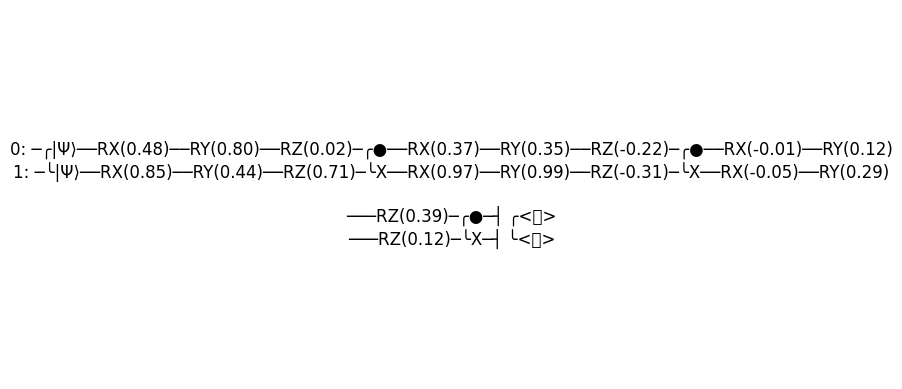

In [171]:
import matplotlib.pyplot as plt

# Assuming 'drawn_circuit' contains the string representation of your circuit
fig, ax = plt.subplots()
ax.text(0.5, 0.5, drawn_circuit, horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')
ax.axis('off')

plt.savefig('circuit_diagram.svg', format='svg')
plt.show()

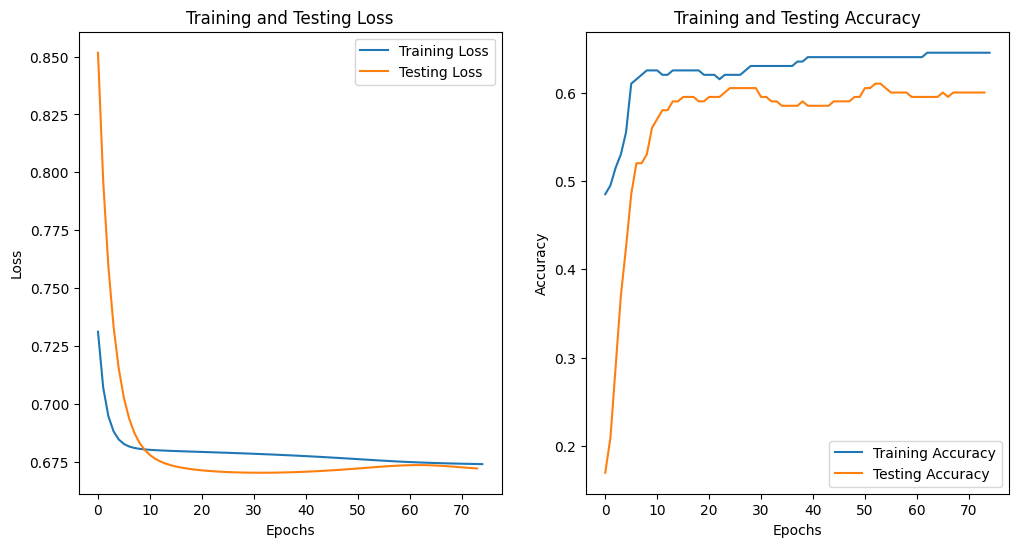

In [160]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Testing Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Save the plots as SVG files
plt.savefig('quantum_model_torch_training_data_001_multiemb_training_testing_plots_002.svg', format='svg')

plt.show()

In [193]:
file_path = 'quantum_model_torch_training_data_001_multiemb.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)
    
best_params = data['best_params']
train_accuracies = data['train_accuracies']
train_losses = data['training_losses']
test_accuracies = data['test_accuracies']
test_losses = data['test_losses']

def test_model(circuit, params, test_data, test_labels, criterion):
    total_test_loss = 0
    correct_test = 0
    test_preds = []

    with torch.no_grad():
        for data, label in zip(test_data, test_labels):
            prediction = torch.sigmoid(circuit(params, data))
            pred_label = (prediction >= 0.5).int()
            test_preds.append(pred_label.item())

            loss = criterion(prediction, label)
            total_test_loss += loss.item()
            correct_test += int(pred_label == label)

    avg_test_loss = total_test_loss / len(test_data)
    test_accuracy = correct_test / len(test_data)

    return avg_test_loss, test_accuracy, test_preds

# Call the function to perform testing
avg_test_loss, test_accuracy, test_predictions = test_model(
    quantum_circuit, best_params, reduced_edge_x_test_torch, y_test_torch, criterion
)


from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Assuming test_labels are your actual labels for the test dataset
confusion_mat = confusion_matrix(y_test_torch, test_predictions)
precision, recall, _, _ = precision_recall_fscore_support(y_test_torch, test_predictions, average='binary')

In [190]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.8 MB/s eta 0:00:00


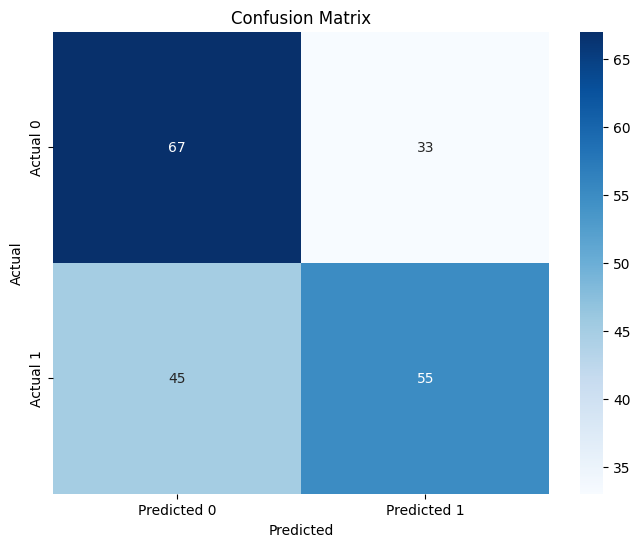

In [191]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_torch, test_predictions)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.svg', format='svg')

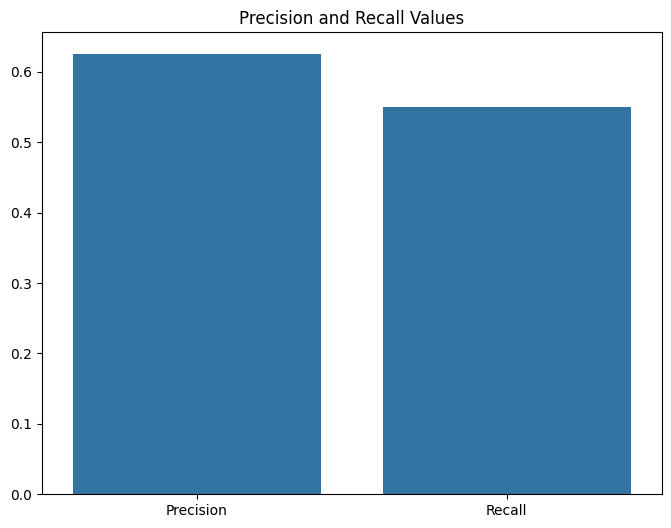

In [192]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision and recall
precision, recall, _, _ = precision_recall_fscore_support(y_test_torch, test_predictions, average='binary')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=['Precision', 'Recall'], y=[precision, recall])
plt.title('Precision and Recall Values')
plt.savefig('precision_recall.svg', format='svg')